# Предварительный анализ

Импорт необходимых библиотек

In [161]:
import pandas as pd
import statistics
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import ttest_ind
import matplotlib.dates as mdates
from matplotlib.ticker import FuncFormatter
import statsmodels.api as sm

Считываем данные

In [162]:
url ="https://dano.hse.ru/mirror/pubs/share/987942268"
data = pd.read_csv(url)
print(data.shape)

(396749, 20)


In [163]:
print(data.info())
print(data.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 396749 entries, 0 to 396748
Data columns (total 20 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   order_rk                 396749 non-null  int64  
 1   party_rk                 396749 non-null  int64  
 2   gender_cd                393828 non-null  object 
 3   age                      396749 non-null  int64  
 4   education_level_cd       190059 non-null  object 
 5   marital_status_cd        217729 non-null  object 
 6   lvn_state_nm             362572 non-null  object 
 7   minute_cost              396749 non-null  float64
 8   activation_cost          396749 non-null  float64
 9   hold_amount              396749 non-null  float64
 10  transport_model          396749 non-null  object 
 11  distance_km              396749 non-null  float64
 12  created_dttm             396749 non-null  object 
 13  book_start_dttm          396749 non-null  object 
 14  book

In [164]:
data.drop_duplicates(inplace=True)

**ОБРАБОТКА АНОМАЛЬНЫХ И НУЛЕВЫХ ЗНАЧЕНИЙ**

In [165]:
print(data.isnull().sum())

order_rk                        0
party_rk                        0
gender_cd                    2921
age                             0
education_level_cd         206690
marital_status_cd          179020
lvn_state_nm                34177
minute_cost                     0
activation_cost                 0
hold_amount                     0
transport_model                 0
distance_km                     0
created_dttm                    0
book_start_dttm                 0
book_end_dttm                   0
book_time_zone_cd               0
local_book_start_dttm           0
nominal_price_rub_amt           0
loyalty_accrual_rub_amt     29757
loyalty_accrual_bns_amt    374801
dtype: int64


Для дальнейшего категориального анализа заменим пропущенные значения на новую группу:

- Для gender_cd (2,921 пропусков ~0.7%)
- Для education_level_cd (206,690 пропусков ~52%)
- Для marital_status_cd (179,020 пропусков ~45%)
- Для lvn_state_nm (34,177 пропусков ~8.6%):


In [166]:
data['gender_cd'] = data['gender_cd'].fillna('Unknown')
data['education_level_cd'] = data['education_level_cd'].fillna('Unknown')
data['marital_status_cd'] = data['marital_status_cd'].fillna('Unknown')
data['lvn_state_nm'] = data['lvn_state_nm'].fillna('Unknown')

Также есть пропущенные значения в полях loyalty_accrual_rub_amt и loyalty_accrual_bns_amt. Так как эти поля отобраэают сумму кэшбека рублями или бонусами соответственно, то отсутствие этих данных говорит об отсутствии кэшбека, следовательно мы можем заменить их на 0.

In [167]:
data['loyalty_accrual_rub_amt'] = data['loyalty_accrual_rub_amt'].fillna(0)
data['loyalty_accrual_bns_amt'] = data['loyalty_accrual_bns_amt'].fillna(0)

In [168]:
print('Отрицательная дистанция:', len(data[data['distance_km'] < 0]))
print("Отрицательная цена аренды", len(data[data['minute_cost'] < 0]))
print("Отрицательная цена активации", len(data[data['activation_cost'] < 0]))
print("Отрицательная цена удержки", len(data[data['hold_amount'] < 0]))
print("Отрицательная стоимость поездки", len(data[data['nominal_price_rub_amt'] < 0]))
print("Отрицательная сумма кэшбека", len(data[data['loyalty_accrual_rub_amt'] < 0]))
print("Отрицательное количество бонусов", len(data[data['loyalty_accrual_bns_amt'] < 0]))
print('Количество пользователей старше 80 лет', len(data[data['age'] > 80]))
print('Количество пользователей младше 18 лет', len(data[data['age'] < 18]))

Отрицательная дистанция: 0
Отрицательная цена аренды 0
Отрицательная цена активации 0
Отрицательная цена удержки 0
Отрицательная стоимость поездки 0
Отрицательная сумма кэшбека 7
Отрицательное количество бонусов 0
Количество пользователей старше 80 лет 117
Количество пользователей младше 18 лет 47


Отрицательная сумма кэшбека не может быть, значит аномалия.

`Очень странно, что в таблице нет информации о подписке пользователя, ведь от нее зависит процент кэшбека`

In [169]:
print(data[data['loyalty_accrual_rub_amt'] < 0])

         order_rk    party_rk gender_cd  age education_level_cd  \
133193  346866316   520065368         F   38                UGR   
218430  350556979  1068354351         F   77            Unknown   
225743  263337728   544337483         M   22            Unknown   
272310  348557969   904357431         M   18                GRD   
297741  266324787   952764064         M   46                SCH   
299220  351047641   759332373         M   27                GRD   
340555  261319091   943073656         M   30                SCH   

       marital_status_cd       lvn_state_nm  minute_cost  activation_cost  \
133193               CIV  Г САНКТ-ПЕТЕРБУРГ         7.99             50.0   
218430               UNM   СВЕРДЛОВСКАЯ ОБЛ         6.49             30.0   
225743           Unknown           Г МОСКВА         8.86             50.0   
272310               UNM  КРАСНОЯРСКИЙ КРАЙ         6.49              0.0   
297741               DIV     МОСКОВСКАЯ ОБЛ         6.99             50.0   
2

Посчитаем среднее значение кэшбека, не учитывая аномальные данные и заменим отрицательные значения ими.

In [170]:
positive_loyalty = data[data['loyalty_accrual_rub_amt'] >= 0]['loyalty_accrual_rub_amt']

mean_positive_loyalty = positive_loyalty.mean()

print(f"Среднее значение кэшбека в рублях (без учета отрицательных значений): {mean_positive_loyalty:.1f}")
data.loc[data['loyalty_accrual_rub_amt'] < 0, 'loyalty_accrual_rub_amt'] = mean_positive_loyalty


print("Отрицательная сумма кэшбека", len(data[data['loyalty_accrual_rub_amt'] < 0]))

Среднее значение кэшбека в рублях (без учета отрицательных значений): 34.7
Отрицательная сумма кэшбека 0


**Визуализация данных**

Построим ящик с усами (box plot), чтобы визуально выявить потенциальные выбросы

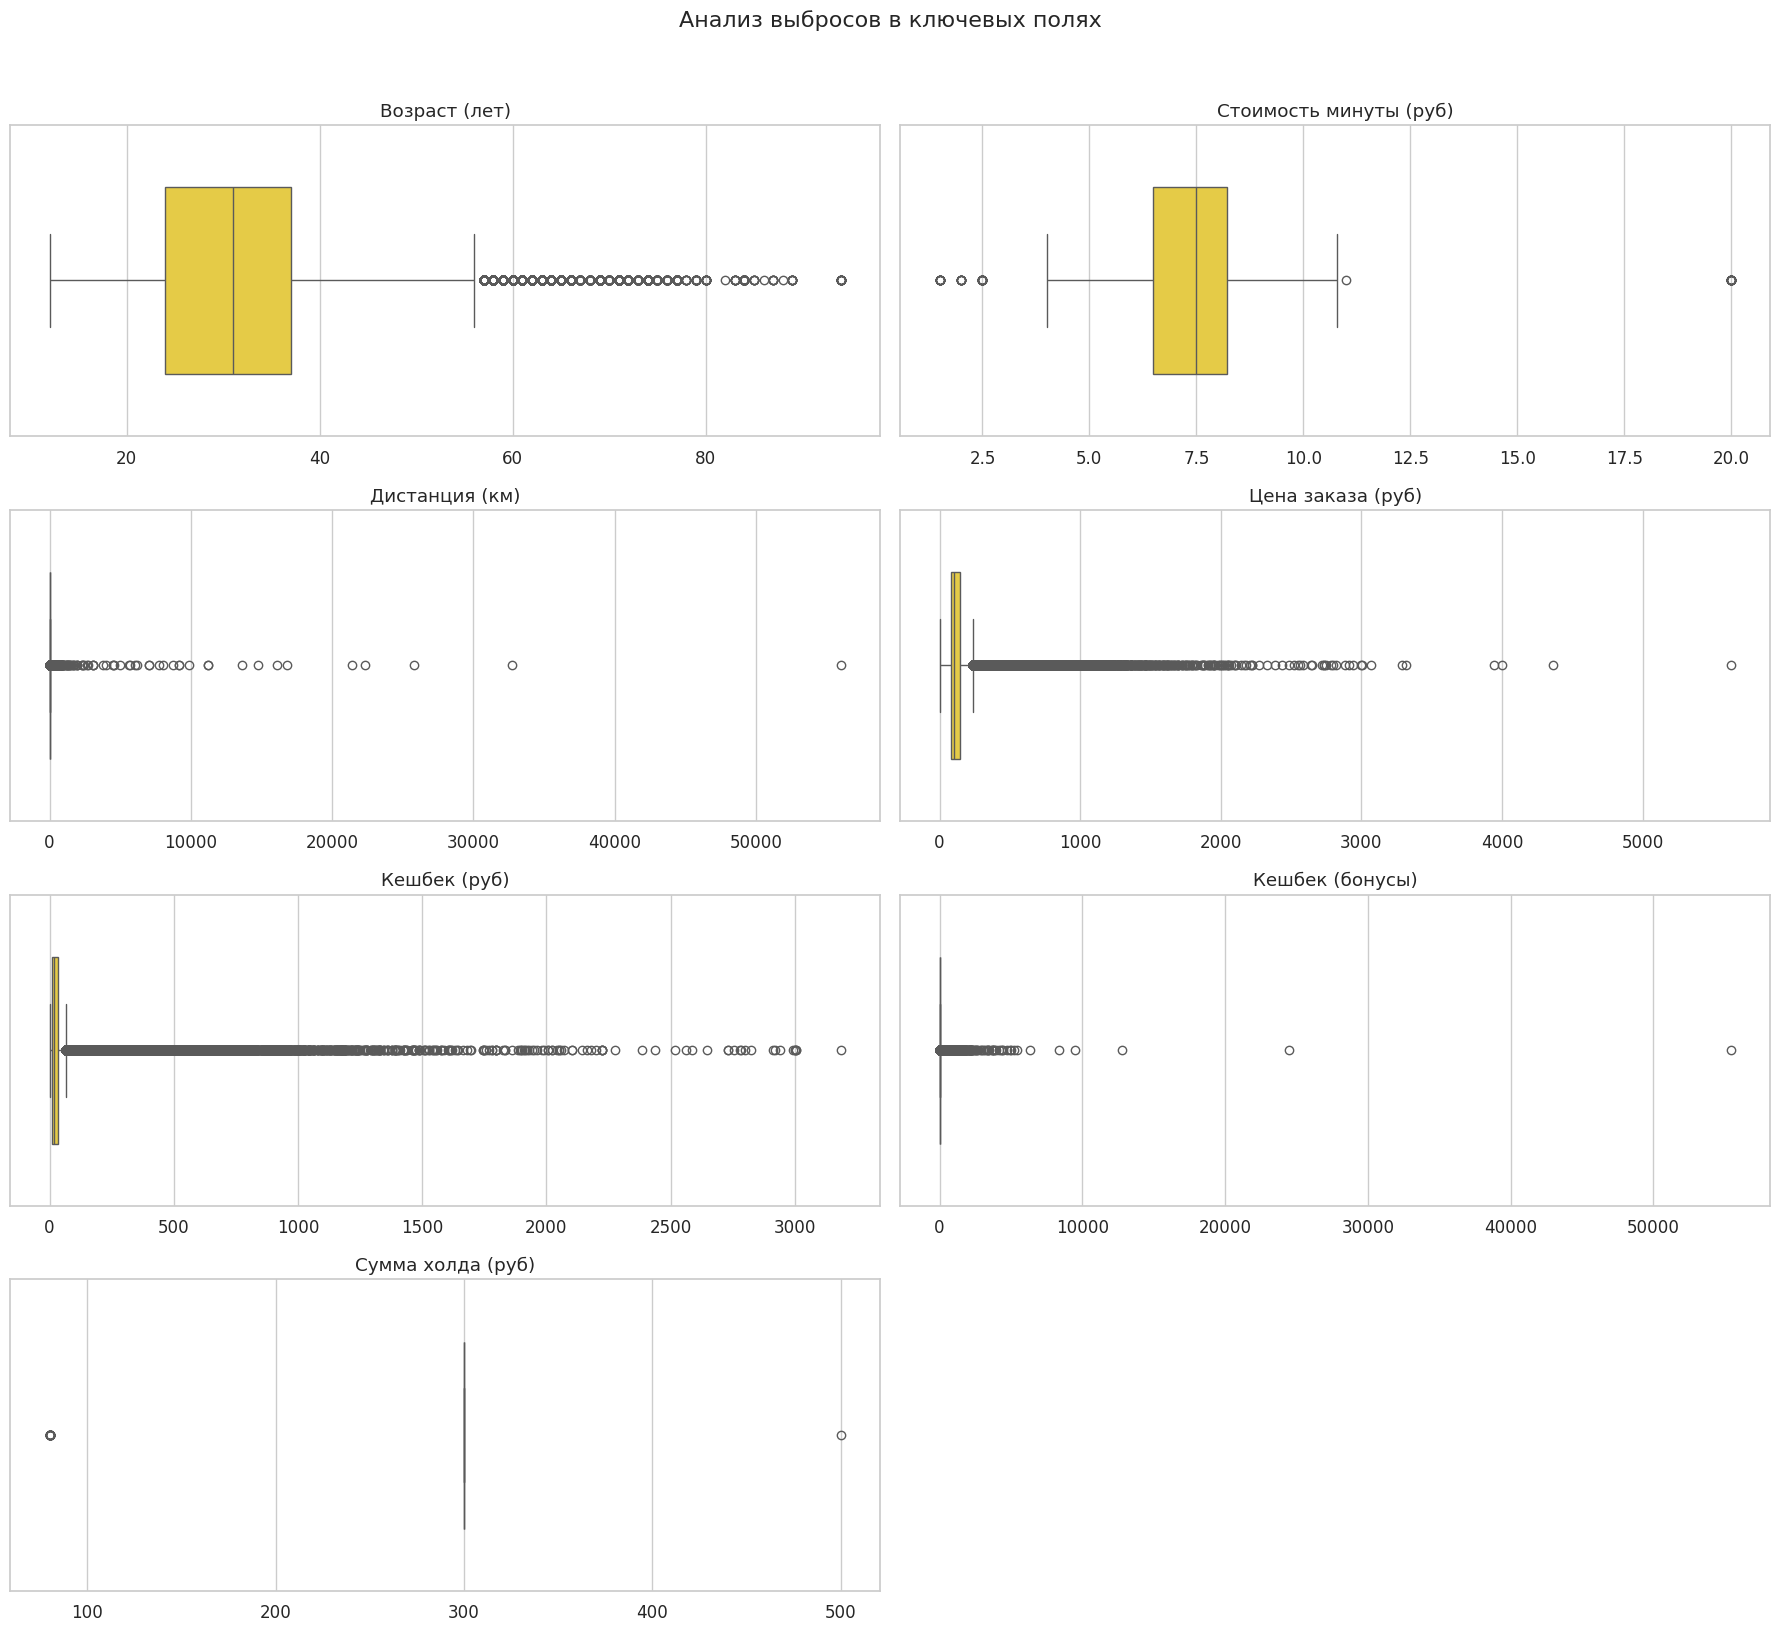

In [171]:
sns.set(style="whitegrid", font_scale=1.1)
plt.rcParams['figure.facecolor'] = 'white'

fields = [
    ('age', 'Возраст', 'лет'),
    ('minute_cost', 'Стоимость минуты', 'руб'),
    ('distance_km', 'Дистанция', 'км'),
    ('nominal_price_rub_amt', 'Цена заказа', 'руб'),
    ('loyalty_accrual_rub_amt', 'Кешбек', 'руб'),
    ('loyalty_accrual_bns_amt', 'Кешбек', 'бонусы'),
    ('hold_amount', 'Сумма холда', 'руб')
]

fig, axes = plt.subplots(4, 2, figsize=(18, 16))
fig.suptitle('Анализ выбросов в ключевых полях', y=1.02, fontsize=16)

for idx, (field, name, unit) in enumerate(fields):
    row = idx // 2
    col = idx % 2

    sns.boxplot(x=data[field], ax=axes[row, col], color='#FFDD2D', width=0.6)
    axes[row, col].set_title(f'{name} ({unit})')
    axes[row, col].set_xlabel('')

for idx in range(len(fields), 8):
    row = idx // 2
    col = idx % 2
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

ВЫВОД:



*   Возраст - есть выбросы (слишком взрослые клиенты). Предположение: услугой пользовался другой человек, но оплата была произведена с карты пожилого клиента банка
*   Дистанция - есть большой выброс в 50000км. Обработаем отдельно

*   Сумма холда фиксированно 300 рублей. Почему у некоторых пользователей не было холда?


*   Кэшбек бонусами - есть аномально большие значения




***Обработка аномальных значений поля distance_km***

In [172]:
# Отсмотрим топ 15 поездок с максимальной дистанцией
data.nlargest(15, 'distance_km')

,order_rk,party_rk,gender_cd,age,education_level_cd,marital_status_cd,lvn_state_nm,minute_cost,activation_cost,hold_amount,transport_model,distance_km,created_dttm,book_start_dttm,book_end_dttm,book_time_zone_cd,local_book_start_dttm,nominal_price_rub_amt,loyalty_accrual_rub_amt,loyalty_accrual_bns_amt
11244,252634726,695658540,M,23,SCH,UNM,ЯРОСЛАВСКАЯ ОБЛ,4.99,30.0,300.0,SL,56012.640308,2024-06-09 00:01:35.000000,2024-06-09 00:01:38.297341,2024-06-09 00:17:38.340000,3,2024-06-09 00:01:38.297341,109.84,10.98,0.0
175173,261054571,293397690,M,30,UGR,UNM,РЕСП МОРДОВИЯ,8.49,30.0,300.0,Max,32742.764788,2024-07-19 13:11:27.000000,2024-07-19 13:11:31.981187,2024-07-19 13:14:31.402906,3,2024-07-19 13:11:31.981187,55.47,7.55,0.0
313313,274439844,58660326,M,34,GRD,MAR,МОСКОВСКАЯ ОБЛ,6.53,50.0,300.0,SL,25834.347823,2024-09-06 07:23:50.000000,2024-09-06 07:23:54.260000,2024-09-06 07:26:38.857011,3,2024-09-06 07:23:54.260000,69.59,13.92,0.0
300080,355425512,865803190,M,31,Unknown,Unknown,Unknown,8.49,50.0,300.0,SL,22317.776290,2024-10-18 12:38:52.000000,2024-10-18 12:38:57.624000,2024-10-18 13:03:44.795520,3,2024-10-18 12:38:57.624000,262.25,48.90,0.0
385466,266073524,70699616,M,46,GRD,MAR,Г МОСКВА,8.49,50.0,300.0,ES100,21402.841155,2024-08-07 13:38:24.000000,2024-08-07 13:38:29.075803,2024-08-07 14:29:19.592234,3,2024-08-07 13:38:29.075803,482.99,72.30,0.0
255453,272403283,315694291,M,35,GRD,UNM,Г МОСКВА,8.37,50.0,300.0,SL,16792.048378,2024-08-30 11:06:05.000000,2024-08-30 11:06:10.796127,2024-08-30 12:31:22.362619,3,2024-08-30 11:06:10.796127,769.82,769.82,0.0
38639,273531461,966004075,M,30,Unknown,Unknown,РЕСП МАРИЙ ЭЛ,7.99,30.0,300.0,Max,16092.447582,2024-09-03 19:26:49.000000,2024-09-03 19:26:53.182376,2024-09-03 19:32:22.172249,3,2024-09-03 19:26:53.182376,77.94,7.79,0.0
149103,262312666,260951848,M,24,Unknown,Unknown,Г МОСКВА,8.40,50.0,300.0,SL,14748.053050,2024-07-24 14:01:22.000000,2024-07-24 14:01:25.811017,2024-07-24 14:03:26.625458,3,2024-07-24 14:01:25.811017,66.80,16.00,0.0
378777,268818006,369824391,M,23,GRD,MAR,ВОРОНЕЖСКАЯ ОБЛ,5.99,30.0,300.0,ES400,13629.192952,2024-08-16 23:44:25.000000,2024-08-16 23:44:28.544750,2024-08-16 23:57:28.438037,3,2024-08-16 23:44:28.544750,107.87,124.05,0.0
37642,253948798,323500746,M,27,UGR,UNM,ВОРОНЕЖСКАЯ ОБЛ,8.04,50.0,300.0,SL,11251.072042,2024-06-22 06:14:38.000000,2024-06-22 06:14:42.066021,2024-06-22 06:20:21.000594,3,2024-06-22 06:14:42.066021,98.24,9.82,0.0


Видим, что, не считая огромной дистанции, данные нормальные. В последнее время имеет место распространенная проблема - неверная геолокация. Скорее всего геолокация пользователя определялась неправильно и из-за этого такие выбросы. Заменим на медиану

In [173]:
REASONABLE_MIN = 0
REASONABLE_MAX = 40

# Вычисляем медиану БЕЗ учета аномалий
normal_distances = data[(data['distance_km'] >= REASONABLE_MIN) &
                       (data['distance_km'] <= REASONABLE_MAX)]['distance_km']
median_distance = normal_distances.median()

print(f"Медианная дистанция (без аномалий): {median_distance:.2f} км")

anomalies_mask = (data['distance_km'] < REASONABLE_MIN) | (data['distance_km'] > REASONABLE_MAX)
data.loc[anomalies_mask, 'distance_km'] = median_distance

Медианная дистанция (без аномалий): 1.73 км


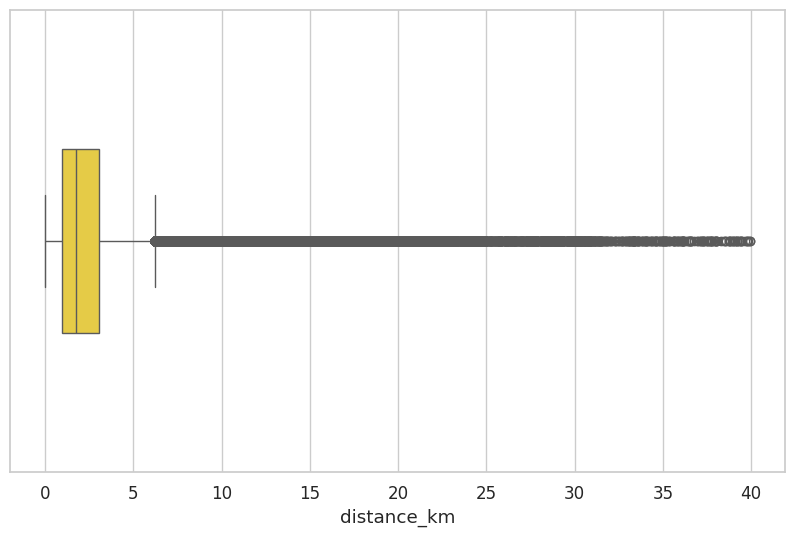

In [174]:
plt.figure(figsize=(10, 6))

sns.boxplot(x=data['distance_km'], color='#FFDD2D', width=0.4)
plt.show()

***Обработка аномальных значений поля hold_amount***

Посмотрим почему не у всех пользователей одинаковая сумма холда

In [175]:
# Посмотрим на данные, где hold_amount ≠ 300
non_standard_holds = data[data['hold_amount'] != 300]

cols_to_show = ['order_rk', 'hold_amount', 'nominal_price_rub_amt',
               'distance_km', 'transport_model']
print(non_standard_holds[cols_to_show].to_string())

         order_rk  hold_amount  nominal_price_rub_amt  distance_km transport_model
16038   266602218         80.0                  78.50     0.000000           Lucky
18608   267910412         80.0                 425.00     0.234842           Lucky
23277   352574532         80.0                  51.00     0.000000           Lucky
44836   266869262         80.0                   0.00     0.000000           Lucky
69424   343269708         80.0                   6.50     0.000000           Lucky
89813   267911352         80.0                  47.00     0.000000           Lucky
103720  277398294         80.0                  47.00     0.000000           Lucky
142392  269365788         80.0                  11.00     0.000000           Lucky
150392  254683488        500.0                  62.45     0.003835           ES100
170831  272070486         80.0                  63.00     0.000000           Lucky
174337  270152318         80.0                  47.00     0.000000           Lucky
1756

In [176]:
standard_holds = data[data['hold_amount'] == 300]
print(standard_holds[cols_to_show].head(5).to_string())

    order_rk  hold_amount  nominal_price_rub_amt  distance_km transport_model
0  266071307        300.0                 134.79     3.690479              SL
1  355113920        300.0                 109.43     1.114912              SL
2  347424551        300.0                  71.93     1.515612               E
3  351562959        300.0                  76.97     0.499411              SL
4  258647149        300.0                 126.89     2.602028              SL


ВЫВОД:
Сумма холда зависит от модели самоката. Выбросов нет

***Обработка аномальных значений поля loyalty_accrual_bns_amt***

Видим, что 94.5% пользователей не пользуются системой лояльности с бонусами, но это и логично, ведь такая система лояльности у клиентов с кредитными картами(Drive, Платинум, All Games и ЛУКОЙЛ).


*Данные взяты из [статьи](https://www.tbank.ru/gorod/blog/why-kicksharing/?internal_source=kicksharing) на официальной страницы Т-банка*

Изучив [информацию](https://www.tbank.ru/bank/help/credit-cards/drive/drive-bonus/get-bonus/) о начислении бонусов можем посчитать средний процент кэшбека бонусами. Из статьи знаем, что бонусы начисляются за каждые 100 рублей, поэтому делим итоговую сумму поездки на 100

In [177]:

valid_bonus = data[(data['loyalty_accrual_bns_amt'] > 0)].copy()

valid_bonus['cashback_percent'] = (valid_bonus['loyalty_accrual_bns_amt'] /
                                   valid_bonus['nominal_price_rub_amt'] / 100) * 100

mean_cashback = valid_bonus['cashback_percent'].mean()
print(f"Средний процент бонусного кэшбека: {mean_cashback:.2f}%")

Средний процент бонусного кэшбека: 1.02%


In [178]:
non_zero_bonuses = data[data['loyalty_accrual_bns_amt'] != 0].sort_values('loyalty_accrual_bns_amt', ascending=False)
display(non_zero_bonuses.head(10))

,order_rk,party_rk,gender_cd,age,education_level_cd,marital_status_cd,lvn_state_nm,minute_cost,activation_cost,hold_amount,transport_model,distance_km,created_dttm,book_start_dttm,book_end_dttm,book_time_zone_cd,local_book_start_dttm,nominal_price_rub_amt,loyalty_accrual_rub_amt,loyalty_accrual_bns_amt
137393,347727529,589416418,M,34,UGR,UNM,СВЕРДЛОВСКАЯ ОБЛ,5.99,30.0,300.0,E,6.392333,2024-09-20 07:30:22.000000,2024-09-20 07:30:26.390000,2024-09-20 15:47:18.289388,5,2024-09-20 09:30:26.390000,3007.03,0.0,55429.36097
235128,269886066,687240520,M,26,SCH,CIV,ИРКУТСКАЯ ОБЛ,8.49,30.0,300.0,Max,3.045302,2024-08-21 02:19:16.000000,2024-08-21 02:19:20.112453,2024-08-21 05:11:01.749310,8,2024-08-21 07:19:20.112453,1490.28,0.0,24483.68130
39868,269077105,1099015016,M,22,Unknown,Unknown,ПСКОВСКАЯ ОБЛ,8.99,30.0,300.0,ES400,15.517862,2024-08-18 11:36:52.000000,2024-08-18 11:36:55.999633,2024-08-18 12:48:48.941261,3,2024-08-18 11:36:55.999633,677.28,0.0,12777.77787
75179,273527252,428031611,F,20,Unknown,Unknown,ИРКУТСКАЯ ОБЛ,8.99,50.0,300.0,Max,17.826689,2024-09-03 19:29:11.000000,2024-09-03 19:29:14.405731,2024-09-03 20:29:15.831266,3,2024-09-03 19:29:14.405731,589.40,0.0,9480.68341
115424,268194777,519640166,M,42,SCH,MAR,РЕСП БАШКОРТОСТАН,9.14,50.0,300.0,SL,5.299238,2024-08-15 08:02:43.000000,2024-08-15 08:02:46.479217,2024-08-15 08:47:00.466162,3,2024-08-15 08:02:46.479217,461.30,0.0,8380.95244
175207,268819295,779293686,F,41,UGR,CIV,КАЛИНИНГРАДСКАЯ ОБЛ,7.49,50.0,300.0,Max,8.610148,2024-08-17 14:18:49.000000,2024-08-17 14:18:53.062330,2024-08-17 14:52:02.394648,2,2024-08-17 13:18:53.062330,304.66,0.0,6333.33338
359490,272404743,1185973068,M,41,Unknown,Unknown,ПСКОВСКАЯ ОБЛ,8.99,30.0,300.0,ES400,2.441573,2024-08-30 01:27:44.000000,2024-08-30 01:27:47.373988,2024-08-30 01:58:41.270458,3,2024-08-30 01:27:47.373988,308.69,0.0,5426.37889
13266,262837092,541943880,M,29,GRD,MAR,КРАСНОДАРСКИЙ КРАЙ,8.49,50.0,300.0,Max,2.511893,2024-07-26 12:15:06.000000,2024-07-26 12:15:10.676551,2024-07-26 13:18:12.773000,3,2024-07-26 12:15:10.676551,593.36,0.0,5190.47622
163413,270721392,635297341,M,38,GRD,DIV,КЕМЕРОВСКАЯ ОБЛАСТЬ - КУЗБАСС,8.85,50.0,300.0,SL,23.938714,2024-08-24 13:20:54.000000,2024-08-24 13:20:57.623200,2024-08-24 14:49:25.805646,3,2024-08-24 13:20:57.623200,837.65,0.0,4971.31729
255355,349391491,942302002,M,36,GRD,MAR,ПРИМОРСКИЙ КРАЙ,7.79,50.0,300.0,Max,3.608159,2024-09-26 11:50:23.000000,2024-09-26 11:50:32.671000,2024-09-26 12:21:34.615000,10,2024-09-26 18:50:32.671000,299.28,0.0,4895.67178


Перерасчитаем  аномально высокие значения по формуле nominal_price_rub_amt / 100 * средний кэшбек

In [179]:
data.loc[data['loyalty_accrual_bns_amt'] > 5000, 'loyalty_accrual_bns_amt'] = \
        data.loc[data['loyalty_accrual_bns_amt'] > 5000, 'nominal_price_rub_amt'] * (mean_cashback / 100)

Проверим, что данные заменили

In [180]:
display(non_zero_bonuses.head(5))

,order_rk,party_rk,gender_cd,age,education_level_cd,marital_status_cd,lvn_state_nm,minute_cost,activation_cost,hold_amount,transport_model,distance_km,created_dttm,book_start_dttm,book_end_dttm,book_time_zone_cd,local_book_start_dttm,nominal_price_rub_amt,loyalty_accrual_rub_amt,loyalty_accrual_bns_amt
137393,347727529,589416418,M,34,UGR,UNM,СВЕРДЛОВСКАЯ ОБЛ,5.99,30.0,300.0,E,6.392333,2024-09-20 07:30:22.000000,2024-09-20 07:30:26.390000,2024-09-20 15:47:18.289388,5,2024-09-20 09:30:26.390000,3007.03,0.0,55429.36097
235128,269886066,687240520,M,26,SCH,CIV,ИРКУТСКАЯ ОБЛ,8.49,30.0,300.0,Max,3.045302,2024-08-21 02:19:16.000000,2024-08-21 02:19:20.112453,2024-08-21 05:11:01.749310,8,2024-08-21 07:19:20.112453,1490.28,0.0,24483.68130
39868,269077105,1099015016,M,22,Unknown,Unknown,ПСКОВСКАЯ ОБЛ,8.99,30.0,300.0,ES400,15.517862,2024-08-18 11:36:52.000000,2024-08-18 11:36:55.999633,2024-08-18 12:48:48.941261,3,2024-08-18 11:36:55.999633,677.28,0.0,12777.77787
75179,273527252,428031611,F,20,Unknown,Unknown,ИРКУТСКАЯ ОБЛ,8.99,50.0,300.0,Max,17.826689,2024-09-03 19:29:11.000000,2024-09-03 19:29:14.405731,2024-09-03 20:29:15.831266,3,2024-09-03 19:29:14.405731,589.40,0.0,9480.68341
115424,268194777,519640166,M,42,SCH,MAR,РЕСП БАШКОРТОСТАН,9.14,50.0,300.0,SL,5.299238,2024-08-15 08:02:43.000000,2024-08-15 08:02:46.479217,2024-08-15 08:47:00.466162,3,2024-08-15 08:02:46.479217,461.30,0.0,8380.95244


На данном этапе видим, что у нас хорошие данные готовые к обработке. Больше нет очевидных аномалий и нулевых значений на важных для расчета данных. Однако странно, что количество пользователей младше 18 лет не равно 0, ведь по условиям арендовать могут только пользователи старше 18 лет.Также есть сомнения, что клиенты старше 80 лет сами пользовались услугой, скорее всего использовали более младшие родственники

# **Сводные статистики**

Посчитаем средние показатели для ключевых полей

In [181]:
key_metrics = {
    'age': 'Возраст',
    'minute_cost': 'Стоимость минуты (руб)',
    'activation_cost': 'Стоимость активации (руб)',
    'hold_amount': 'Стоимость изначальной удержки (руб)',
    'distance_km': 'Дистанция (км)',
    'nominal_price_rub_amt': 'Цена (руб)',
    'loyalty_accrual_rub_amt': 'Лояльность (руб)',
    'loyalty_accrual_bns_amt': 'Лояльность (бонусы)'
}


key_stats = pd.DataFrame()

for col, desc in key_metrics.items():
    if col in data.columns:
        key_stats.loc[desc, 'Среднее'] = data[col].mean()
        key_stats.loc[desc, 'Медиана'] = data[col].median()
        key_stats.loc[desc, 'Разница'] = abs(data[col].mean() - data[col].median())
        key_stats.loc[desc, 'Минимум'] = data[col].min()
        key_stats.loc[desc, 'Максимум'] = data[col].max()


print(key_stats.round(1).to_string())

                                     Среднее  Медиана  Разница  Минимум  Максимум
Возраст                                 31.5     31.0      0.5     12.0      94.0
Стоимость минуты (руб)                   7.3      7.5      0.2      1.5      20.0
Стоимость активации (руб)               42.6     50.0      7.4      0.0      50.0
Стоимость изначальной удержки (руб)    300.0    300.0      0.0     80.0     500.0
Дистанция (км)                           2.4      1.7      0.7      0.0      39.9
Цена (руб)                             127.6    103.9     23.7      0.0    5627.6
Лояльность (руб)                        34.7     17.1     17.6      0.0    3185.0
Лояльность (бонусы)                      6.7      0.0      6.7      0.0    4971.3


# **Исследование корреляций между переменными**

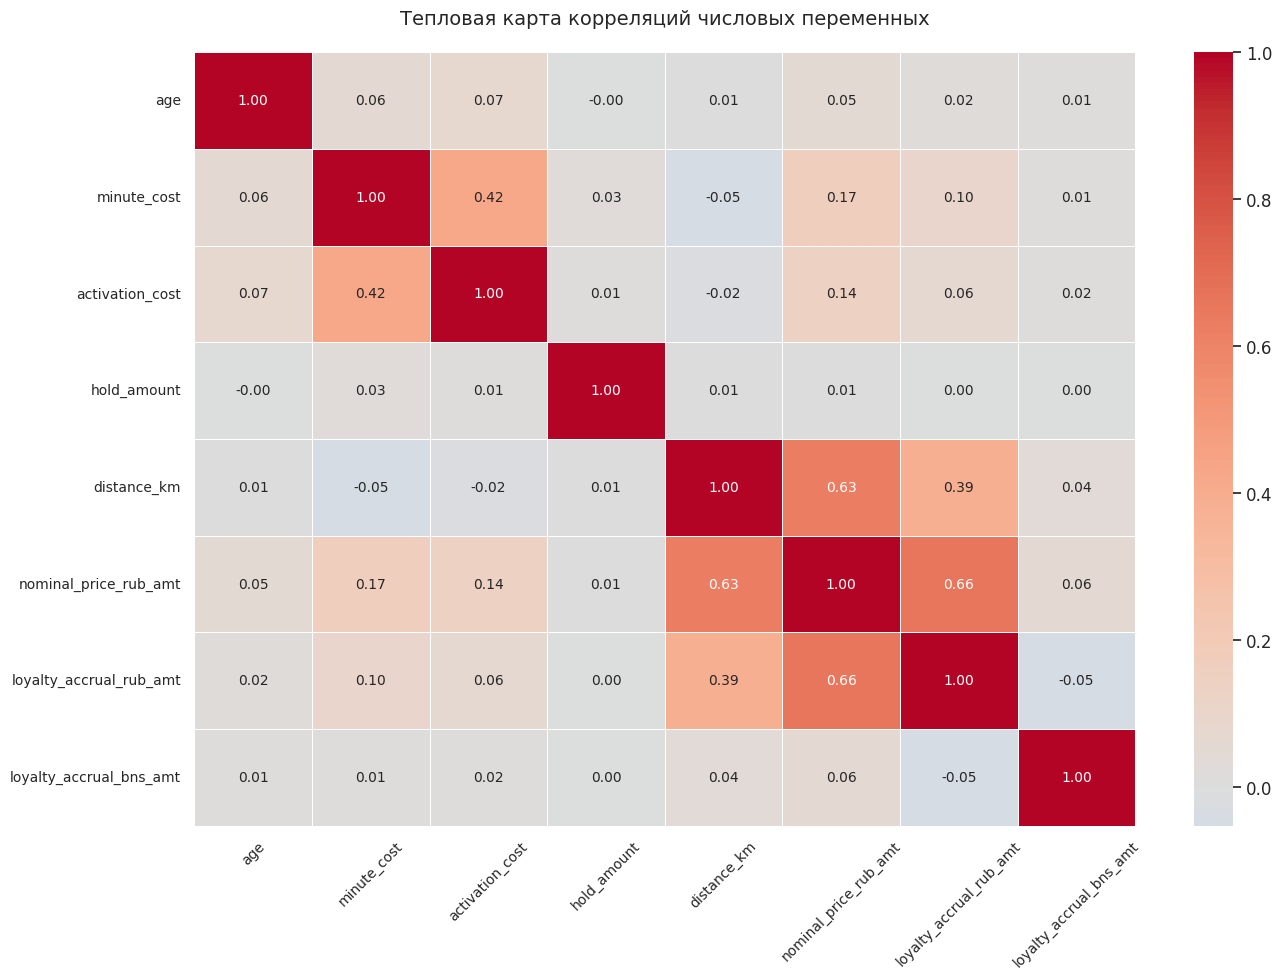

In [182]:
num_cols = data.select_dtypes(include=['float64', 'int64']).columns.tolist()
num_cols = [col for col in num_cols if col not in ['order_rk', 'party_rk', 'book_time_zone_cd']]

corr_matrix = data[num_cols].corr()
plt.figure(figsize=(14, 10))
sns.heatmap(corr_matrix,
            annot=True,
            cmap='coolwarm',
            center=0,
            fmt=".2f",
            linewidths=0.5,
            annot_kws={"size": 10})
plt.title('Тепловая карта корреляций числовых переменных', pad=20, fontsize=14)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

Выбирем 5 самых сильных корреляций

In [183]:
corr_series = corr_matrix.unstack().sort_values(key=abs, ascending=False)
top_correlations = corr_series[corr_series != 1].drop_duplicates().head(5)
for pair, value in top_correlations.items():
    print(f"{pair[0]} и {pair[1]}: {value:.2f}")

loyalty_accrual_rub_amt и nominal_price_rub_amt: 0.66
distance_km и nominal_price_rub_amt: 0.63
minute_cost и activation_cost: 0.42
distance_km и loyalty_accrual_rub_amt: 0.39
minute_cost и nominal_price_rub_amt: 0.17


5 топ-корреляций положительные

Сходится с представлением о мире:

- Чем больше дистанция или чем дороже цена минуты, тем выше итоговый чек и тем больше кэшбек
- Во время повышенного спроса цена одной минуты становится выше и одновременно цена активации. Положительная корреляция тоже объяснима

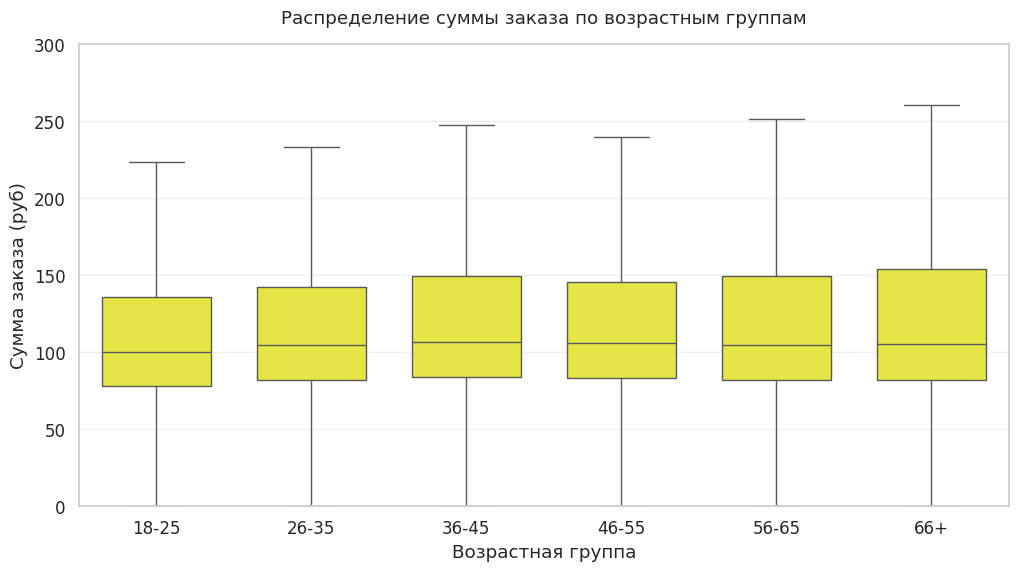

In [184]:
plt.figure(figsize=(12, 6))
data['age_group'] = pd.cut(data['age'],
                          bins=[18, 25, 35, 45, 55, 65, 80],
                          labels=['18-25', '26-35', '36-45', '46-55', '56-65', '66+'])

sns.boxplot(
    x='age_group',
    y='nominal_price_rub_amt',
    data=data,
    color='#ffff2b',
    showfliers=False,
    width=0.7
)
plt.title('Распределение суммы заказа по возрастным группам', pad=15)
plt.xlabel('Возрастная группа')
plt.ylabel('Сумма заказа (руб)')
plt.ylim(0, 300)
plt.grid(axis='y', alpha=0.3)

Видим, что сумма заказа пользователей в возрасте 18-25 лет чуть ниже посравнению с остальными группами

# **Изучение категориальных переменных**

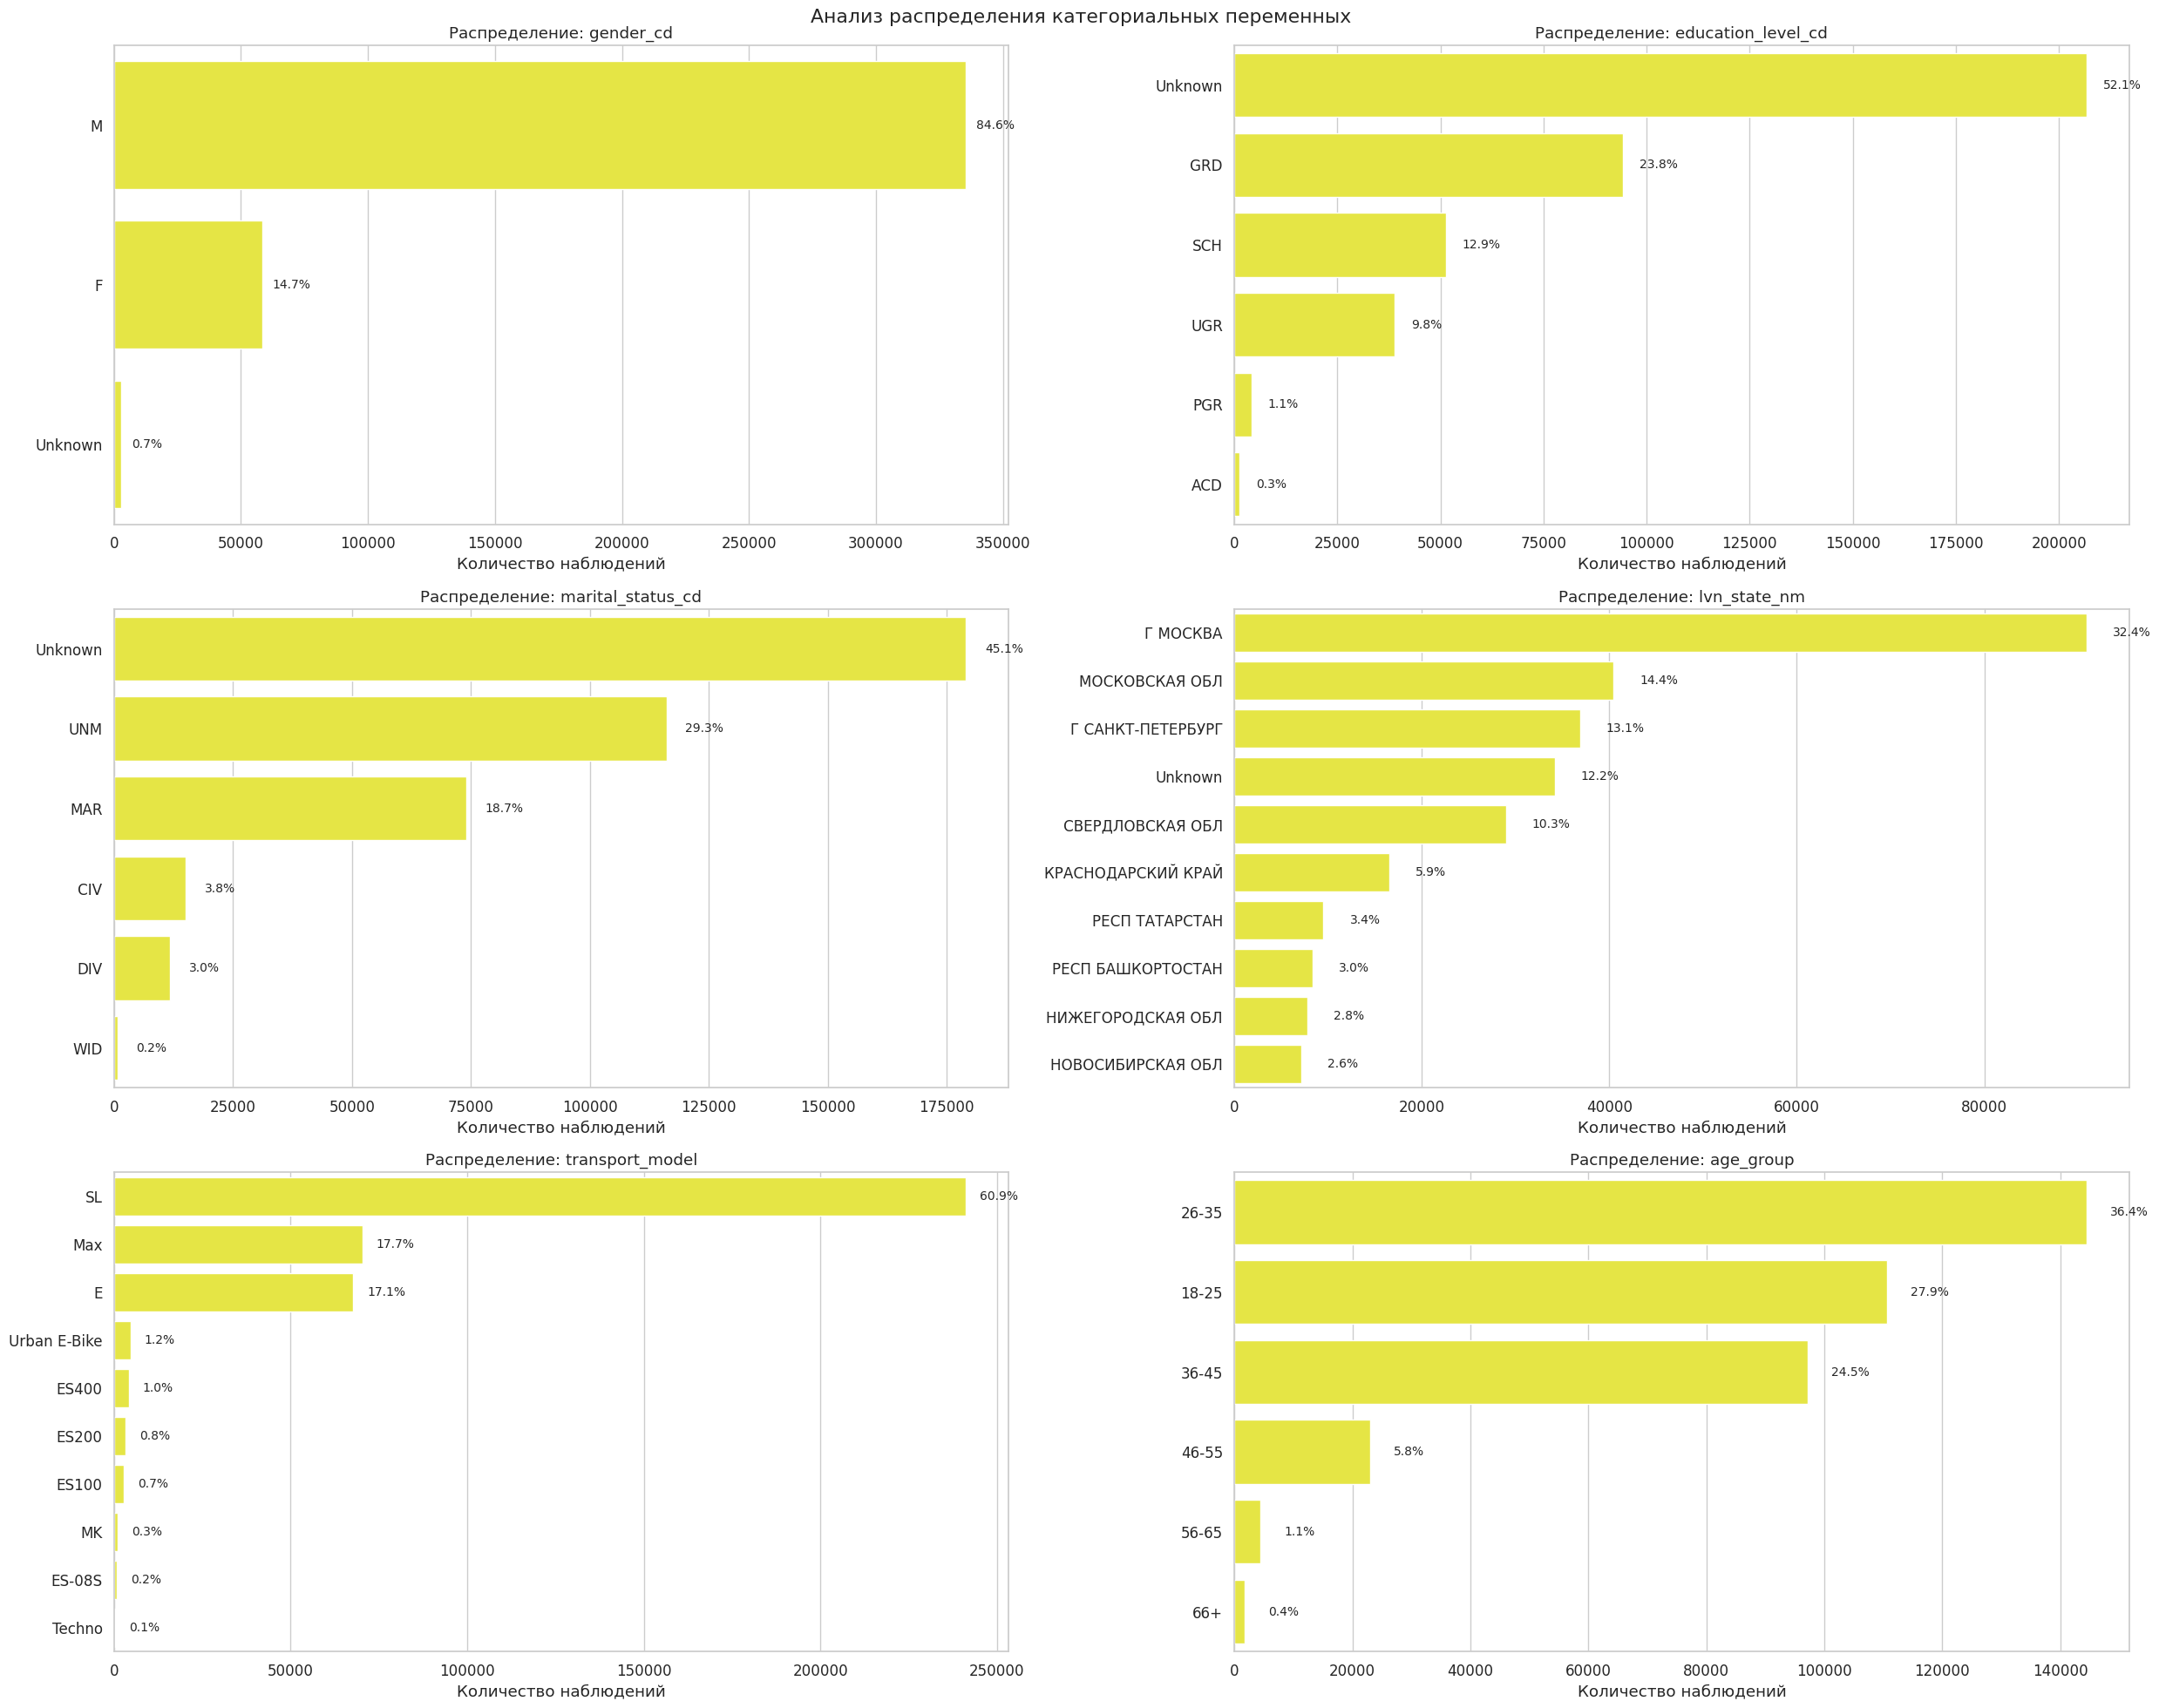

In [185]:
color = '#ffff2b'
cat_cols = [col for col in data.select_dtypes(include=['object', 'category']).columns
            if col not in ['created_dttm', 'book_start_dttm', 'book_end_dttm',
                    'local_book_start_dttm']]

n_cols = 2
n_rows = 3

fig, axes = plt.subplots(n_rows, n_cols, figsize=(25, 20))
fig.suptitle('Анализ распределения категориальных переменных')

for idx, column in enumerate(cat_cols):
    row = idx // n_cols
    col = idx % n_cols
    if data[column].nunique() > 10:
        top_categories = data[column].value_counts().nlargest(10).index
        filtered_data = data[data[column].isin(top_categories)]
        order = top_categories
    else:
        filtered_data = data
        order = data[column].value_counts().index

    current_ax = axes[row, col] if n_rows > 1 else axes[col]

    sns.countplot(y=column,
                 data=filtered_data,
                 order=order,
                 color=color,
                 ax=current_ax)

    current_ax.set_title(f'Распределение: {column}')
    current_ax.set_xlabel('Количество наблюдений')
    current_ax.set_ylabel('')

    total = len(filtered_data)
    for p in current_ax.patches:
        percentage = 100 * p.get_width()/total
        current_ax.text(p.get_width() + 0.01*total,
                       p.get_y() + p.get_height()/2,
                       f'{percentage:.1f}%',
                       va='center',
                       fontsize=10)

for idx in range(len(cat_cols), n_rows * n_cols):
    row = idx // n_cols
    col = idx % n_cols
    if n_rows > 1:
        axes[row, col].axis('off')
    else:
        axes[col].axis('off')

plt.tight_layout()
plt.show()

Почему так мало девушек пользуется сервисом?

# **Анализ распределения числовых переменных**

Посмотрим как много пользователей арендовали самокат и проехали маленькую дистанцию

In [186]:
print('Очень маленькая дистанция:', len(data[data['distance_km'] < 0.1]))

Очень маленькая дистанция: 25567


Проезд дистанции меньше, чем 100 метров, может говорить о том, что клиент остался недоволен качеством самоката(был какой-то брак) из-за чего ему пришлось прервать поездку

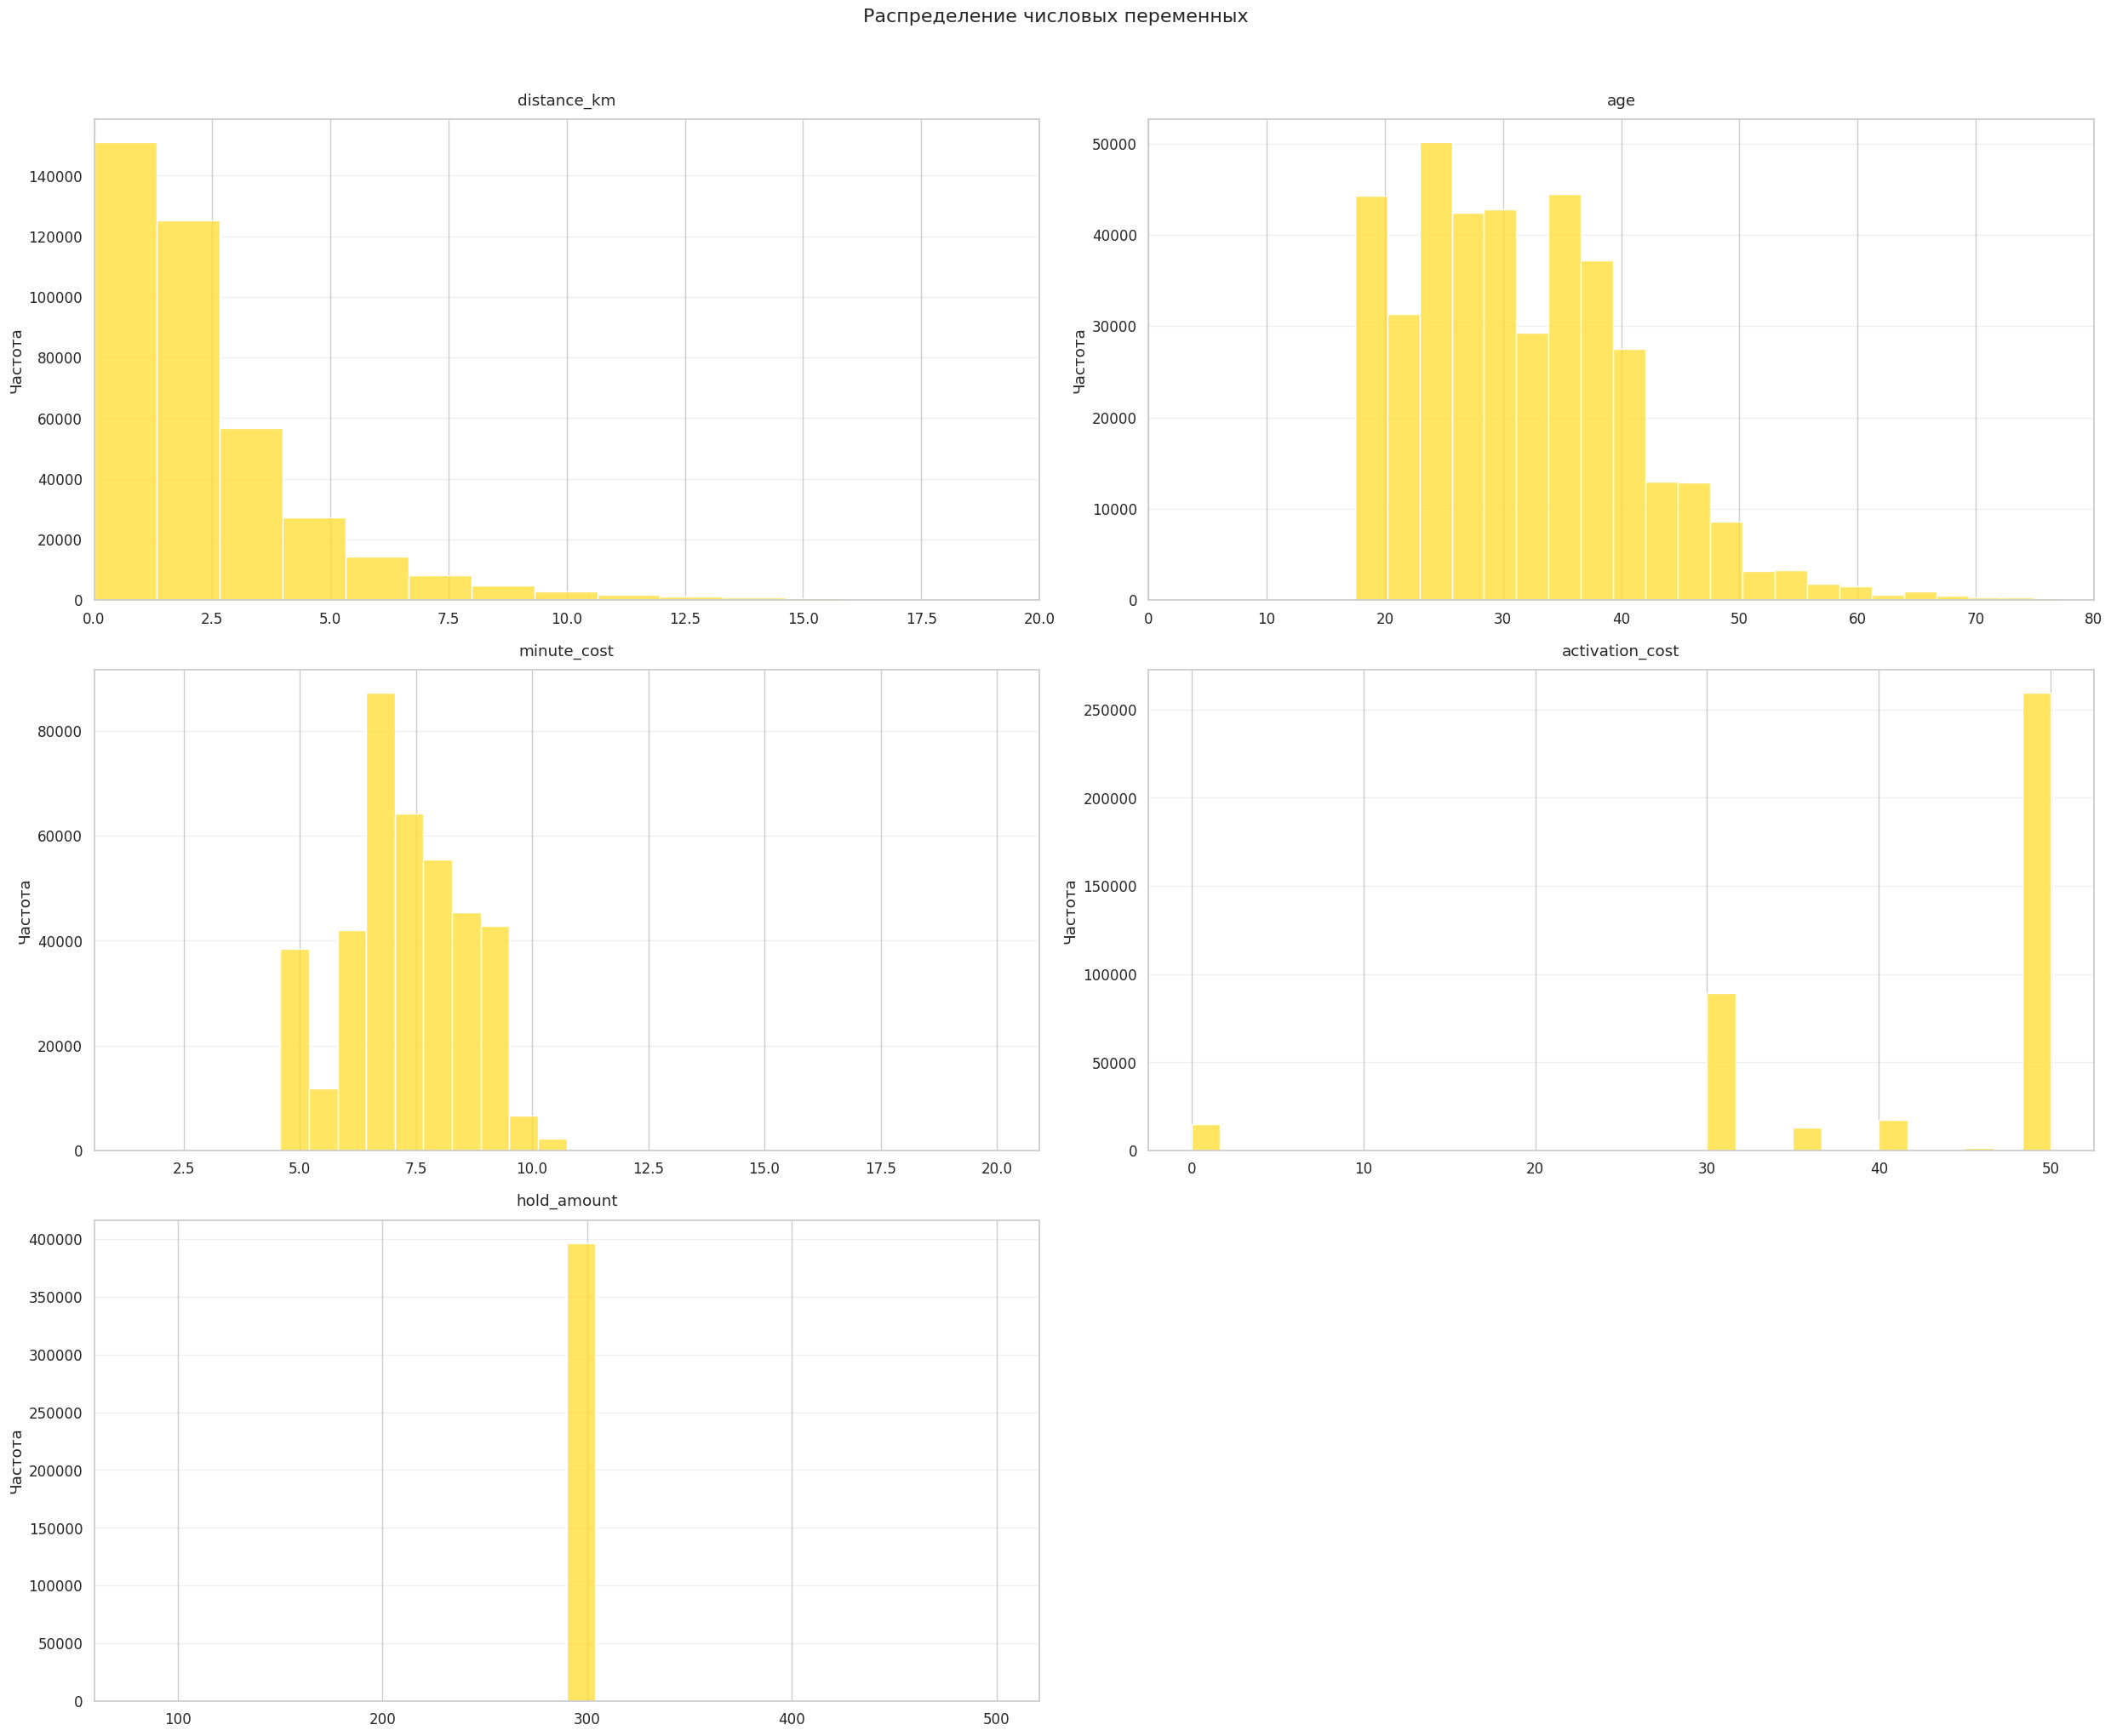

In [187]:
other_cols = ['distance_km', 'age', 'minute_cost', 'activation_cost', 'hold_amount']
other_limits = {
    'distance_km': (0, 20),
    'age': (0, 80)
}

n_cols = 2
n_rows = 3
fig, axes = plt.subplots(n_rows, n_cols, figsize=(25, 20))
fig.suptitle('Распределение числовых переменных', y=1.02, fontsize=16)

for idx, col in enumerate(other_cols):
    row = idx // n_cols
    col_pos = idx % n_cols

    sns.histplot(data[col], ax=axes[row, col_pos], bins=30, color='#FFDD2D')

    if col in other_limits:
        axes[row, col_pos].set_xlim(other_limits[col])

    axes[row, col_pos].set_title(f'{col}', pad=12)
    axes[row, col_pos].set_xlabel('')
    axes[row, col_pos].set_ylabel('Частота')
    axes[row, col_pos].grid(axis='y', alpha=0.3)


for idx in range(len(other_cols), n_rows*n_cols):
    axes.flatten()[idx].axis('off')

plt.tight_layout()
plt.show()

Выводы:
- Чаще люди берут самокат на короткие дистанции до 2,5 км
- ЦА люди в возрасте 20-40 лет
- В зависимости от спроса цена минуты колеблется от 5 до 10 рублей, но чаще всего 7 рублей

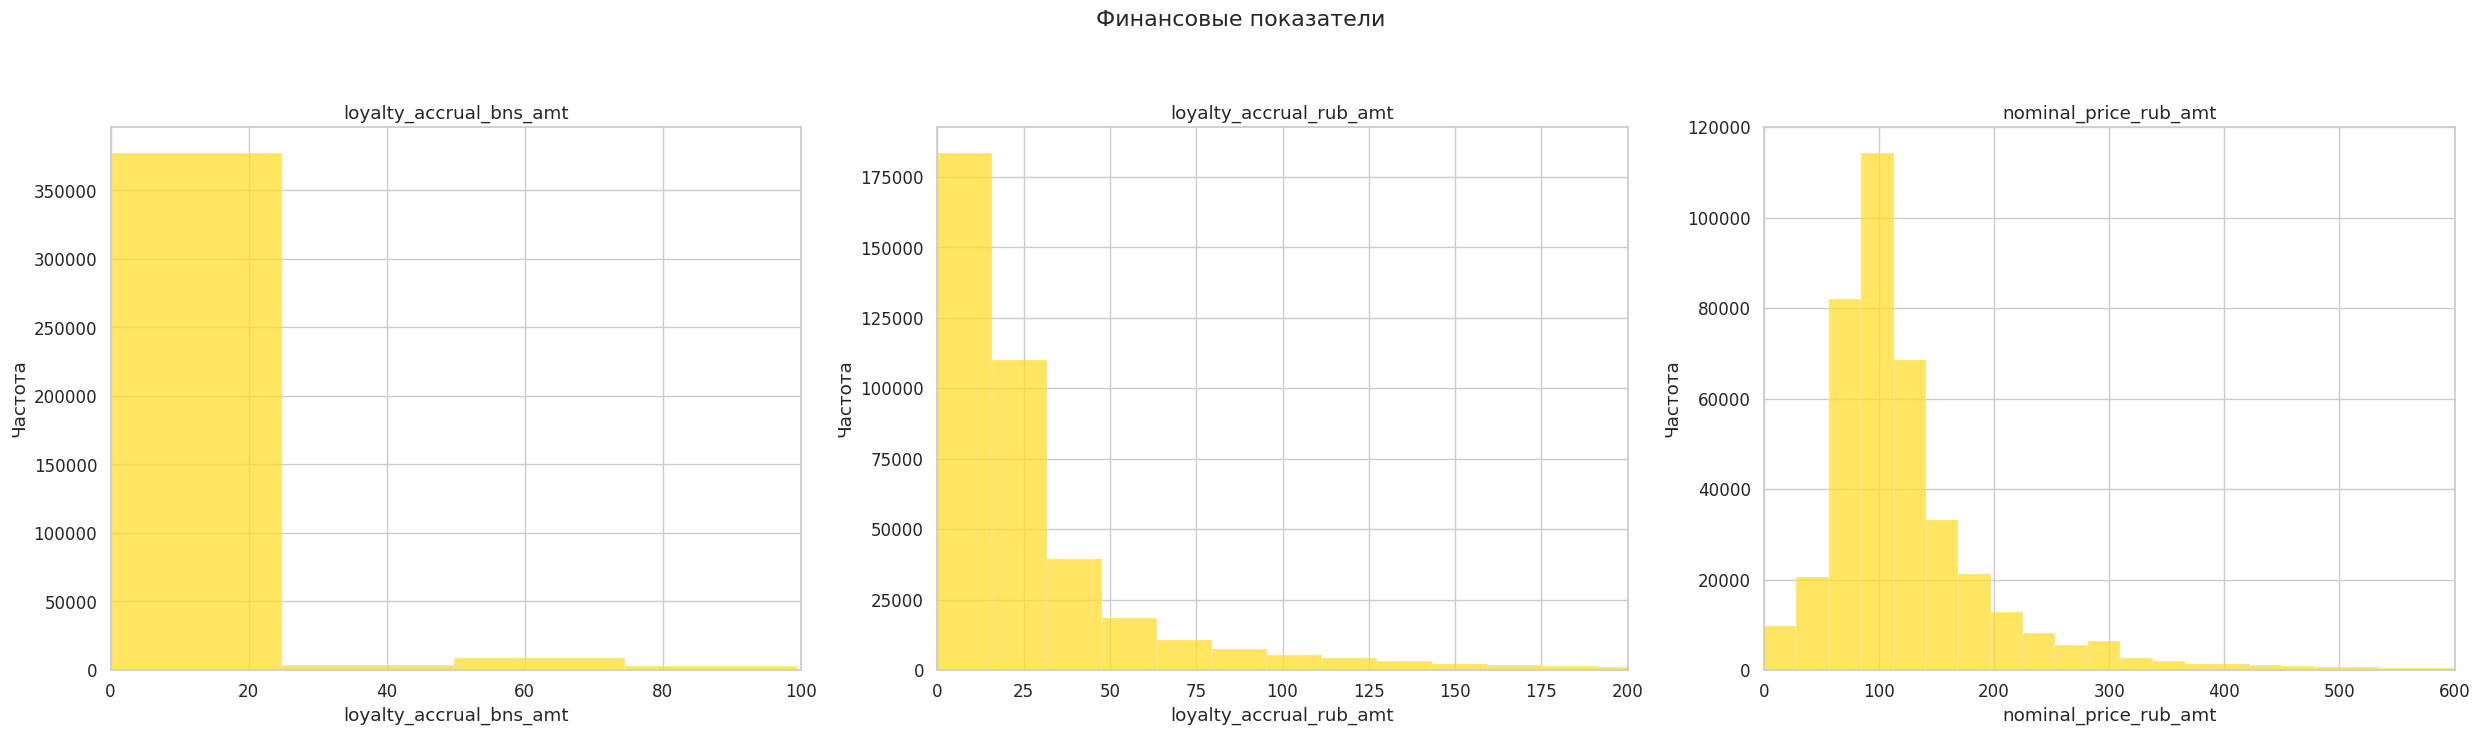

In [188]:
financial_cols = ['loyalty_accrual_bns_amt', 'loyalty_accrual_rub_amt', 'nominal_price_rub_amt']
financial_limits = {
    'loyalty_accrual_bns_amt': (0, 100),
    'loyalty_accrual_rub_amt': (0, 200),
    'nominal_price_rub_amt': (0, 600)
}

plt.figure(figsize=(25, 7))
for idx, col in enumerate(financial_cols, 1):
    plt.subplot(1, 3, idx)
    sns.histplot(data[col], bins=200, color='#FFDD2D')

    if col in financial_limits:
        plt.xlim(financial_limits[col])

    plt.title(col)
    plt.ylabel('Частота')

plt.suptitle('Финансовые показатели', y=1.05, fontsize=16)
plt.tight_layout()
plt.show()

# **Анализ временных переменных**

Посмотрим распределение дат создания заказов

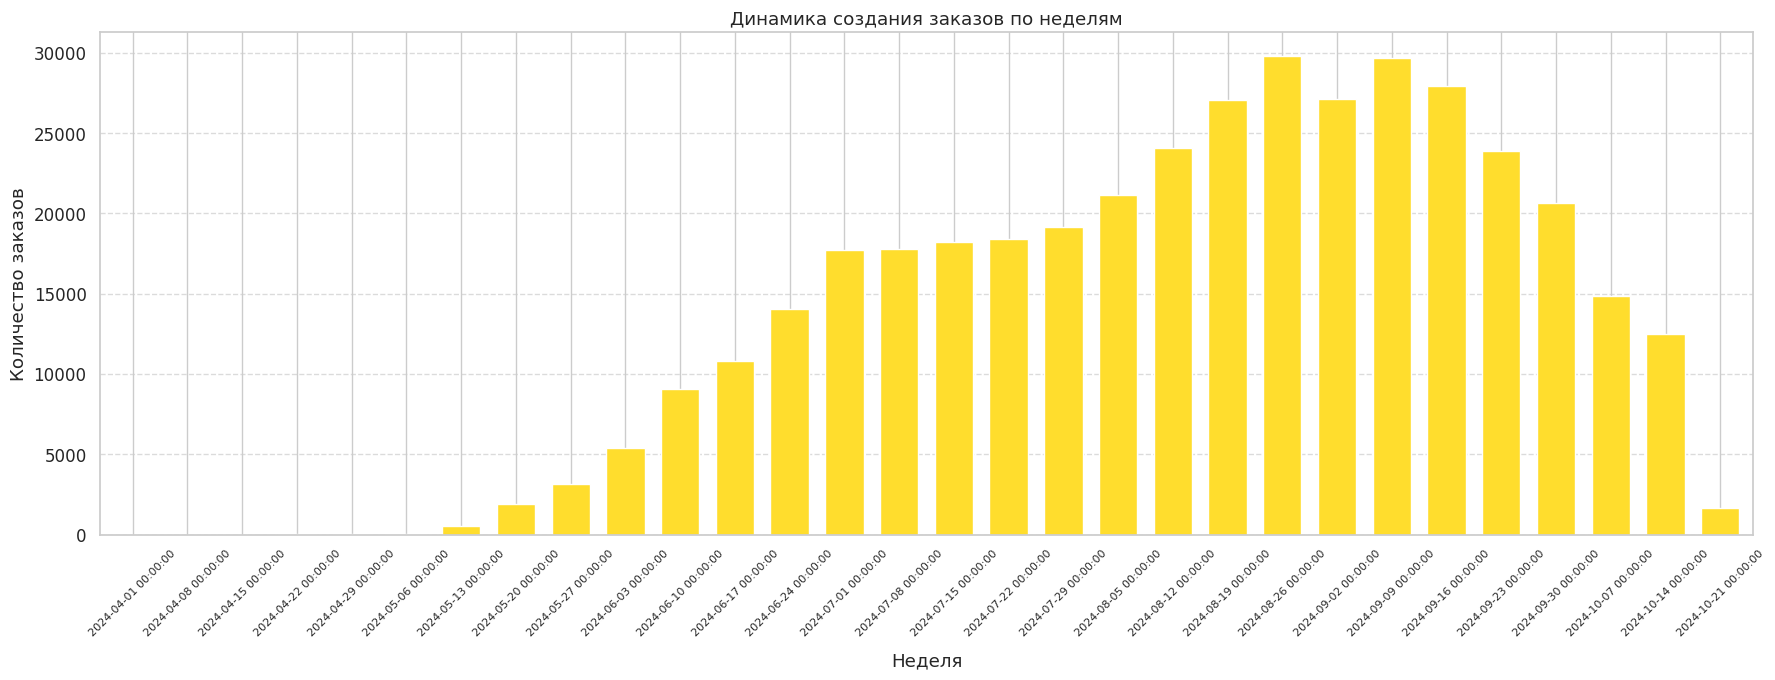

In [189]:
time_cols = ['created_dttm', 'book_start_dttm', 'book_end_dttm', 'local_book_start_dttm']
for col in time_cols:
    if col in data.columns:
        data[col] = pd.to_datetime(data[col])
if 'created_dttm' in time_cols:
    data['created_week'] = data['local_book_start_dttm'].dt.to_period('W').dt.start_time
    orders_by_week = data.groupby('created_week').size()

    plt.figure(figsize=(18, 7))
    orders_by_week.plot(kind='bar', color='#FFDD2D', width=0.7)

    plt.title('Динамика создания заказов по неделям')
    plt.xlabel('Неделя', labelpad=10)
    plt.ylabel('Количество заказов')
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    plt.xticks(rotation=45, fontsize=8)
    plt.tight_layout()
    plt.show()


Анализ времени бронирования


Статистика продолжительности бронирования (в минутах):
count    396749.000000
mean         11.440989
std          13.174834
min           0.033400
25%           4.763057
50%           7.768650
75%          13.371040
max         715.172206
Name: booking_duration, dtype: float64


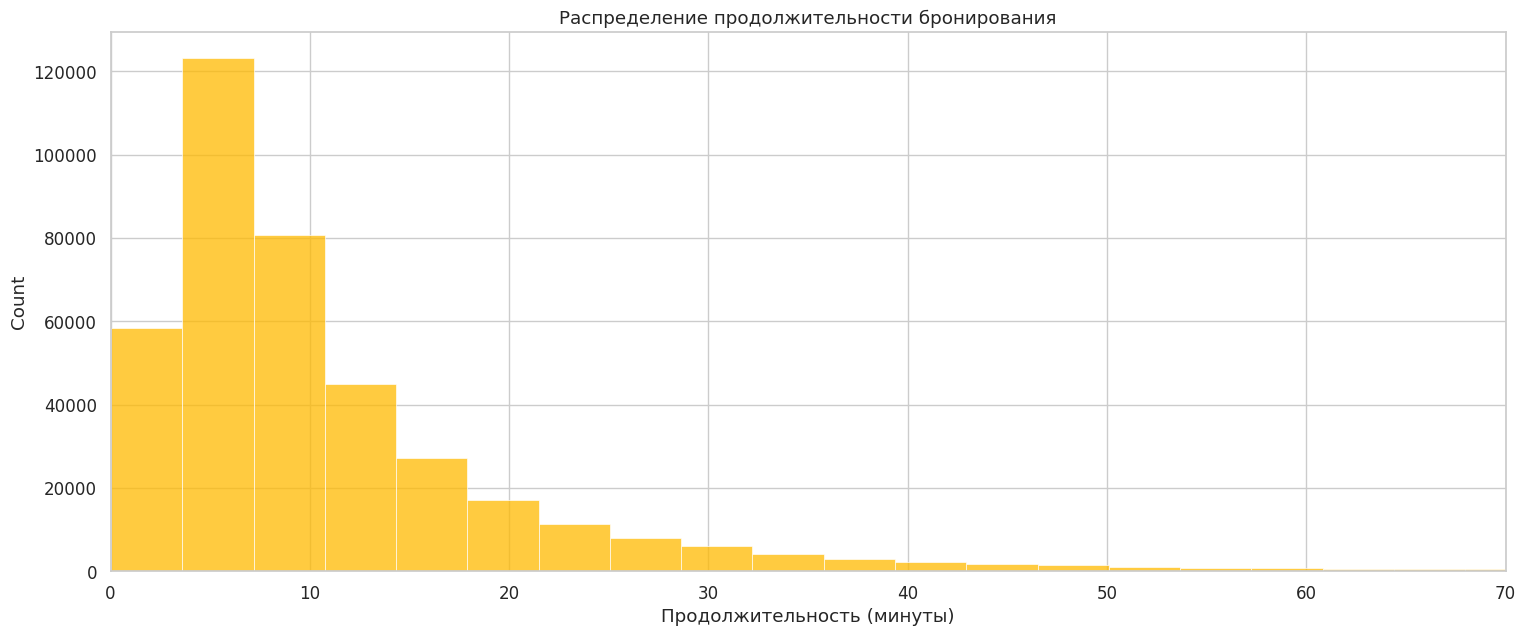

In [190]:
if all(col in data.columns for col in ['book_start_dttm', 'book_end_dttm']):
    data['booking_duration'] = (data['book_end_dttm'] - data['book_start_dttm']).dt.total_seconds() / 60
    print("\nСтатистика продолжительности бронирования (в минутах):")
    print(data['booking_duration'].describe())

    plt.figure(figsize=(18, 7))
    sns.histplot(data['booking_duration'], bins=200, color='#FFBA00')
    plt.title('Распределение продолжительности бронирования')
    plt.xlabel('Продолжительность (минуты)')
    plt.xlim(0, 70)
    plt.show()



Преобладают корткие поездки(до 10 минут)

Посмотрим как распределены количество заказов в зависимости от дня недели

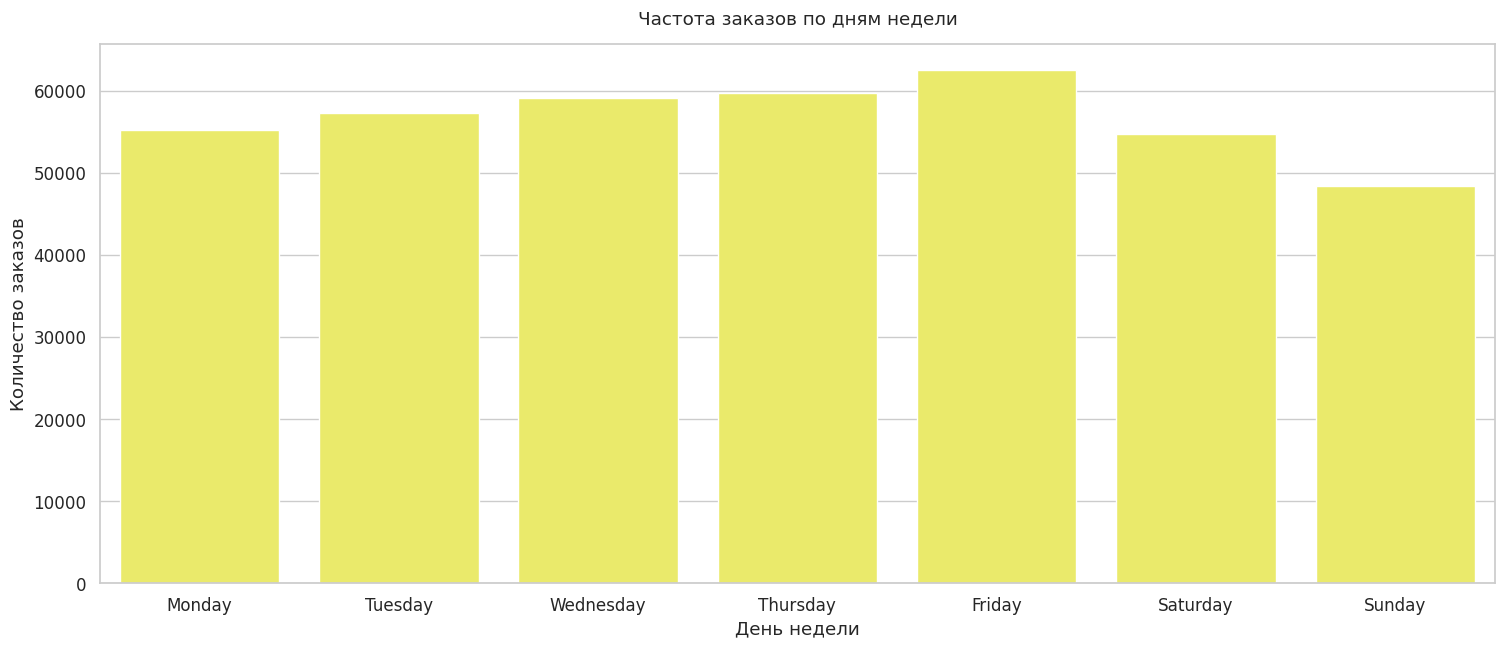

In [191]:
if 'created_dttm' in data.columns:
    data['day_of_week'] = data['local_book_start_dttm'].dt.dayofweek
    data['day_name'] = data['local_book_start_dttm'].dt.day_name()

    weekday_counts = data.groupby(['day_of_week', 'day_name']).size().reset_index(name='counts')
    weekday_counts = weekday_counts.sort_values('day_of_week')

    plt.figure(figsize=(18, 7))
    sns.barplot(
        x='day_name',
        y='counts',
        data=weekday_counts,
        color='#ffff56',
        order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    )
    plt.title('Частота заказов по дням недели', pad=15)
    plt.xlabel('День недели')
    plt.ylabel('Количество заказов')
    plt.show()

Видим, что заказов в будние дни больше, чем заказов в выходные. Возможно люди чаще выбирают самокат, чтобы быстрее добраться до работы: сократить время пути от дома до метро/от метро до работы, чем для прогулок

Посмотрим распределение количества заказов в зависимости от времени суток

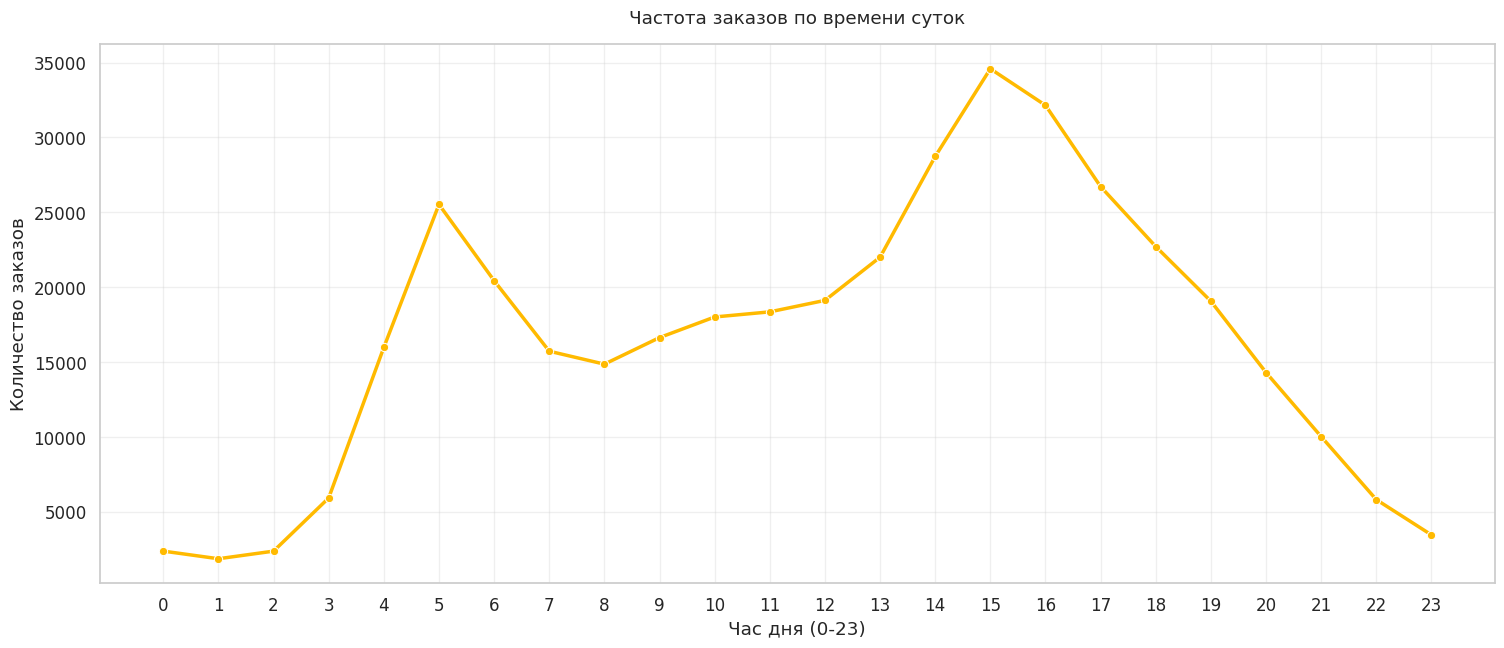

In [192]:
if 'created_dttm' in data.columns:
    data['hour'] = data['local_book_start_dttm'].dt.hour
    hour_counts = data['hour'].value_counts().sort_index().reset_index()
    hour_counts.columns = ['hour', 'counts']

    plt.figure(figsize=(18, 7))
    sns.lineplot(
        x='hour',
        y='counts',
        data=hour_counts,
        marker='o',
        color='#FFBA00',
        linewidth=2.5
    )

    plt.title('Частота заказов по времени суток', pad=15)
    plt.xlabel('Час дня (0-23)')
    plt.ylabel('Количество заказов')
    plt.xticks(np.arange(0, 24, 1))
    plt.grid(axis='both', alpha=0.3)

    plt.show()

Пики наблюдаются в час пик: с 5 до 7 утра и с 15 до 19

Чтобы получить полное представление о распределении заказов в зависимости от времени, давайте рассмотрим количество заказов по каждому часу в течение недели

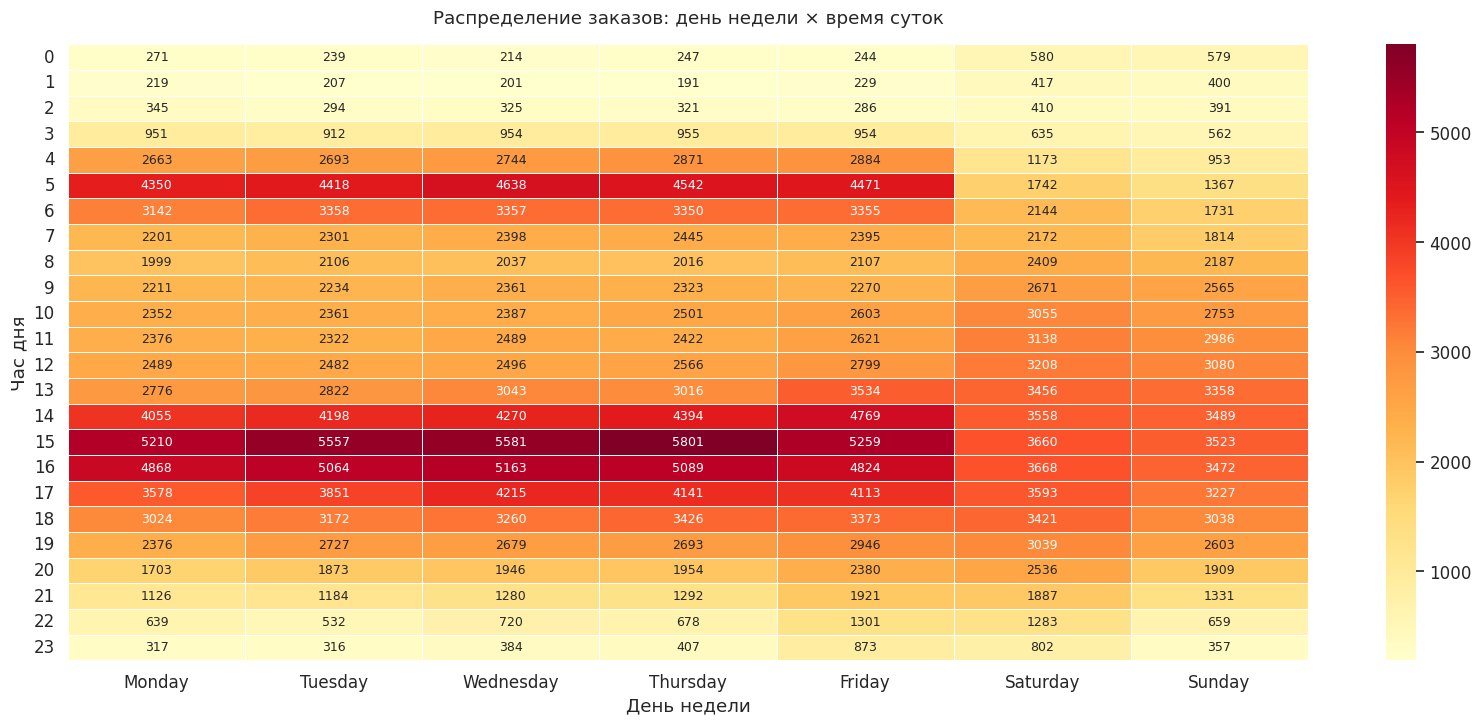

In [193]:
if 'created_dttm' in data.columns:
    pivot_data = data.pivot_table(
        index='hour',
        columns='day_name',
        values='local_book_start_dttm',
        aggfunc='count',
        fill_value=0
    )[['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']]

    plt.figure(figsize=(20, 8))
    sns.heatmap(
        pivot_data,
        cmap='YlOrRd',
        annot=True,
        fmt='d',
        linewidths=0.5,
        annot_kws={'size': 9}
    )
    plt.title('Распределение заказов: день недели × время суток', pad=15)
    plt.xlabel('День недели')
    plt.ylabel('Час дня')
    plt.yticks(rotation=0)
    plt.show()

Вывод:
Чаще всего сервисом пользуются с 4 до 6 утра и с 14 до 18 утра в будний день. С 10 до 20 в выходной день

Анализ средней суммы заказа по времени

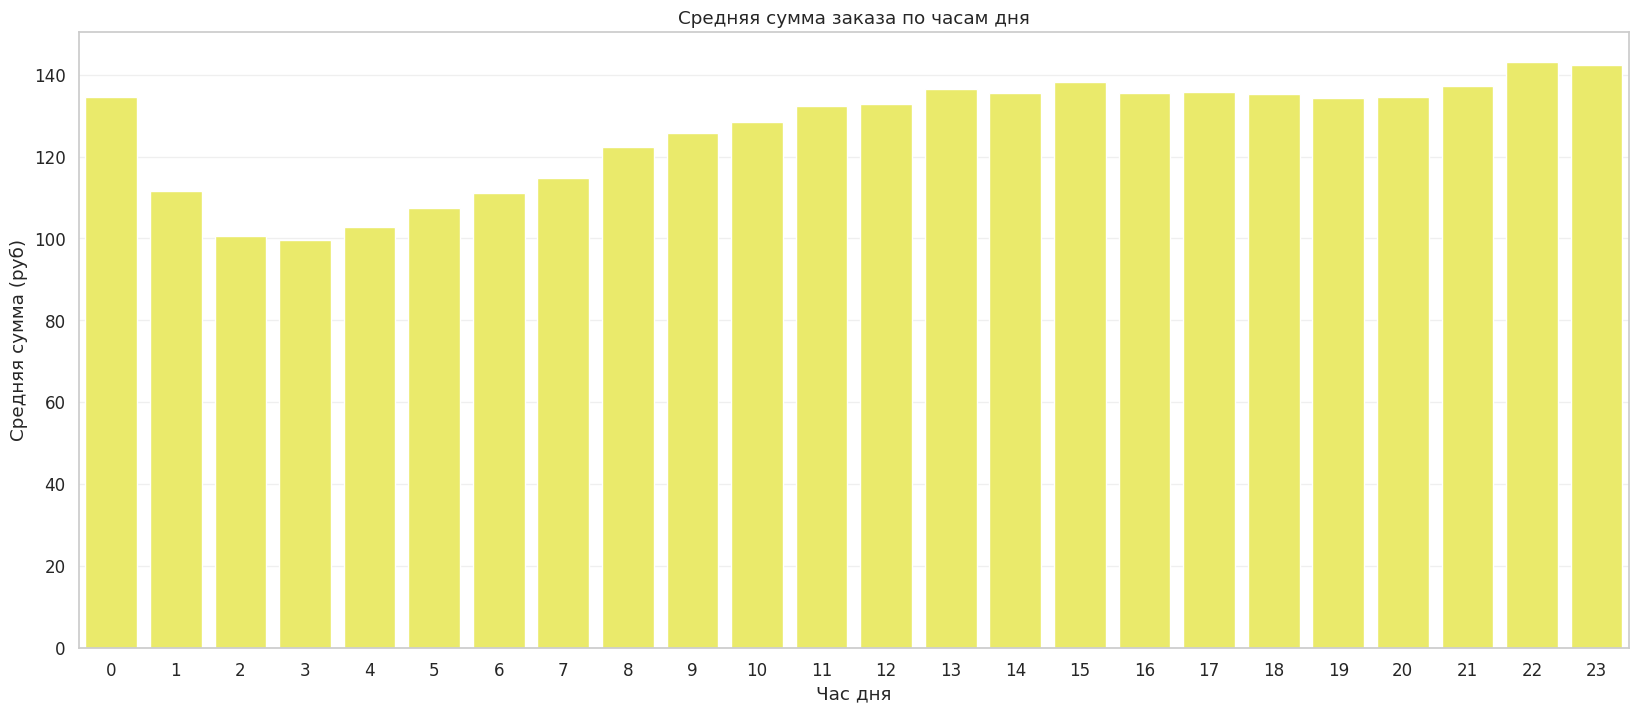

In [194]:
if all(col in data.columns for col in ['local_book_start_dttm', 'nominal_price_rub_amt']):
    data['hour'] = data['created_dttm'].dt.hour
    hourly_avg = data.groupby('hour')['nominal_price_rub_amt'].mean().reset_index()

    plt.figure(figsize=(20, 8))
    sns.barplot(x='hour', y='nominal_price_rub_amt', data=hourly_avg,
                color='#ffff56')
    plt.title('Средняя сумма заказа по часам дня')
    plt.xlabel('Час дня')
    plt.ylabel('Средняя сумма (руб)')
    plt.xticks(np.arange(0, 24, 1))
    plt.grid(axis='y', alpha=0.3)
    plt.show()